## Загрузка и подготовка данных

In [1]:
import functools as ft
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt

from catboost import CatBoostClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve 
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# записываю параметр random_state
r_s = 290822

In [3]:
df_internet = pd.read_csv('/Users/pgagp/Downloads/final_provider/internet.csv')

In [4]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [5]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Пропусков в данном датасете нет, тип всех данных - object.

In [6]:
df_internet.duplicated().sum()

0

явных дубликатов нет

In [7]:
df_internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


все столбцы кроме customerID категориальные, посмотрю на графике как они распределяются

In [8]:
# формирую датасет без столбца customerID
data = df_internet.drop('customerID', axis=1)

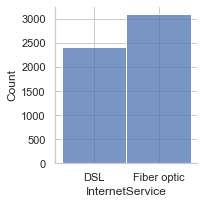

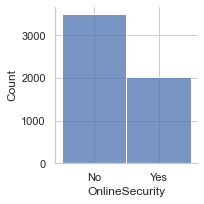

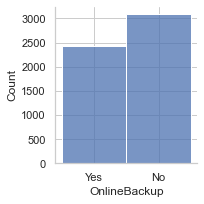

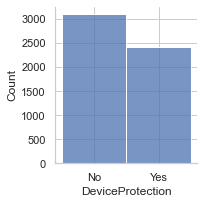

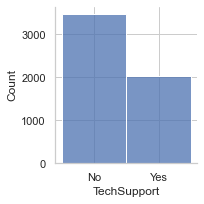

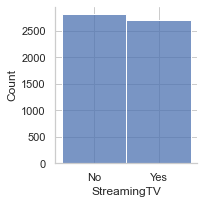

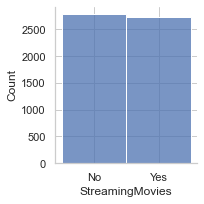

In [9]:
for col in data:
    sns.set_theme(style='whitegrid')
    s = sns.FacetGrid(data=data)
    s.map(sns.histplot, col)

Большая часть пользователей подключена используют подключение через оптоволоконный кабель из дополнительных усулуг предпочитают стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

### Информация об услугах телефонии

In [10]:
df_phone = pd.read_csv('/Users/pgagp/Downloads/final_provider/phone.csv')

In [11]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [12]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Также пропусков нет, тип данных - object

In [13]:
df_phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

In [14]:
df_phone.duplicated().sum()

0

Явных дубликатов нет, 47% пользователей пользуются MultipleLines

### Информация о договоре

In [15]:
df_contract = pd.read_csv('/Users/pgagp/Downloads/final_provider/contract.csv')

In [16]:
df_contract1 = df_contract.copy()

In [17]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [18]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


В датасете лучше изменить типы данных в столбцах BeginDate, EndDate и TotalCharges. \
Из описания проекта известно, что выгрузка на 1 февраля 2020 года, поэтому заменяю No на дату выгрузки.

In [19]:
df_contract['EndDate'] = df_contract['EndDate'].replace(['No'], ['2020-02-01'])

In [20]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format='%Y-%m-%d')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], format='%Y-%m-%d')
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors ='coerce')

Формирую новый столбец с информацией о количестве дней со дня подключения к услугам Телекома.

In [21]:
df_contract['Total_days'] = (df_contract['EndDate'] - df_contract['BeginDate']).dt.days
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Total_days        7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


In [22]:
df_contract.isna().sum()

customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Total_days           0
dtype: int64

после преобразований появились пропуски в столбце TotalCharges, посмотрю на них более детально

In [23]:
df_contract[np.isnan(df_contract['TotalCharges'])]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Total_days
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0


для сравнения выведу изначальный датафрейм

In [24]:
df_contract1[df_contract1['BeginDate'] == '2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Пропуски в TotalCharges потому, что данные пользователи подключились к Телекому в день выгрузки датасетов. \
Заполню данными по 0 руб.

In [25]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].fillna(0)

Month-to-month    55.019168
Two year          24.066449
One year          20.914383
Name: Type, dtype: float64


<AxesSubplot:xlabel='Type', ylabel='Count'>

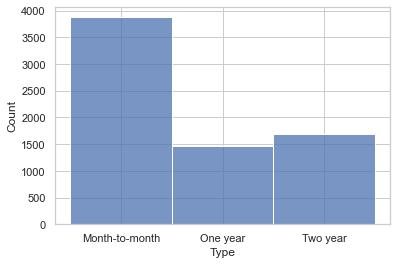

In [26]:
print(df_contract['Type'].value_counts(normalize=True) * 100)
sns.histplot(data = df_contract['Type'])

Electronic check             33.579441
Mailed check                 22.887974
Bank transfer (automatic)    21.922476
Credit card (automatic)      21.610109
Name: PaymentMethod, dtype: float64


<AxesSubplot:xlabel='PaymentMethod', ylabel='Count'>

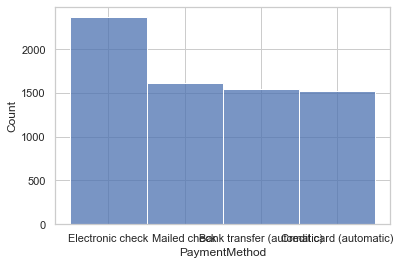

In [27]:
print(df_contract['PaymentMethod'].value_counts(normalize=True) * 100)
sns.histplot(data = df_contract['PaymentMethod'])

55% плятят ежемесячно. \
24% платят за 2 года. \
21% платят за 1 год.

In [28]:
df_contract.describe()

,MonthlyCharges,TotalCharges,Total_days
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,985.996166
std,30.090047,2266.794470,747.587844
min,18.250000,0.000000,0.000000
25%,35.500000,398.550000,273.000000
50%,70.350000,1394.550000,883.000000
75%,89.850000,3786.600000,1676.000000
max,118.750000,8684.800000,2191.000000


<AxesSubplot:>

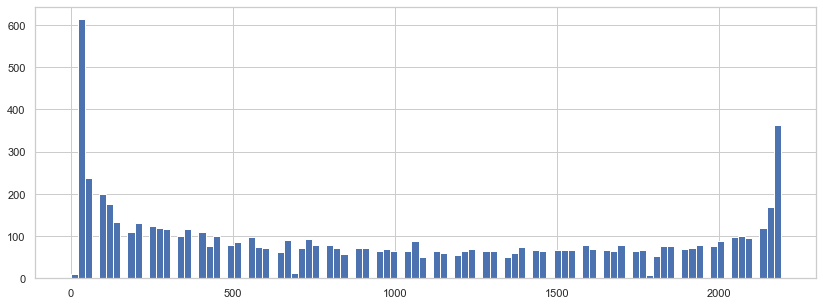

In [29]:
df_contract['Total_days'].hist(bins=100, figsize=(14, 5))

по графику видно, что больше всего пользователей которые только подключились, а также тех кто подключился одними из первых

<AxesSubplot:>

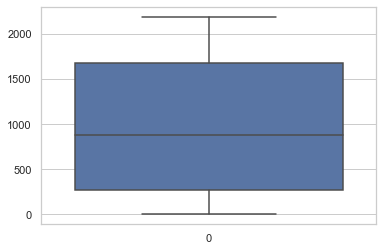

In [30]:
sns.set_theme(style='whitegrid')
sns.boxplot(data=df_contract['Total_days'])

In [31]:
df_contract['Total_days'].value_counts().head(10)

31      431
2191    362
30      182
92      169
2163    164
153     133
61      123
123     118
365     117
62      115
Name: Total_days, dtype: int64

аномалий нет

### Персональные данные клиента

In [32]:
df_personal = pd.read_csv('/Users/pgagp/Downloads/final_provider/personal.csv')

In [33]:
df_personal.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [34]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [35]:
per = df_personal.drop('customerID', axis=1)

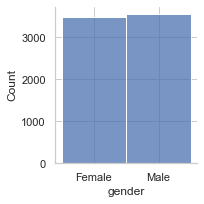

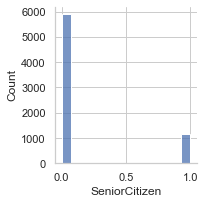

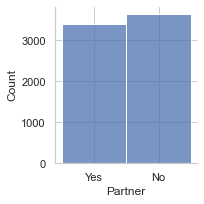

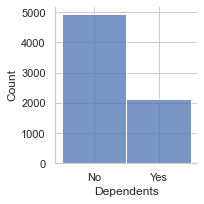

In [36]:
for col in per:
    sns.set_theme(style='whitegrid')
    s = sns.FacetGrid(data=per)
    s.map(sns.histplot, col)

## Обучение моделей

### Подготовка данных к обучению

объединяю все датасеты в один

In [37]:
dfs = [df_contract, df_personal, df_internet, df_phone]
df = ft.reduce(lambda left, right: pd.merge(left, right, on='customerID', how='outer'), dfs)
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Total_days,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,31,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,1036,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,1371,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Total_days        7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity    5517 n

посмотрю распределение пропусков

<AxesSubplot:>

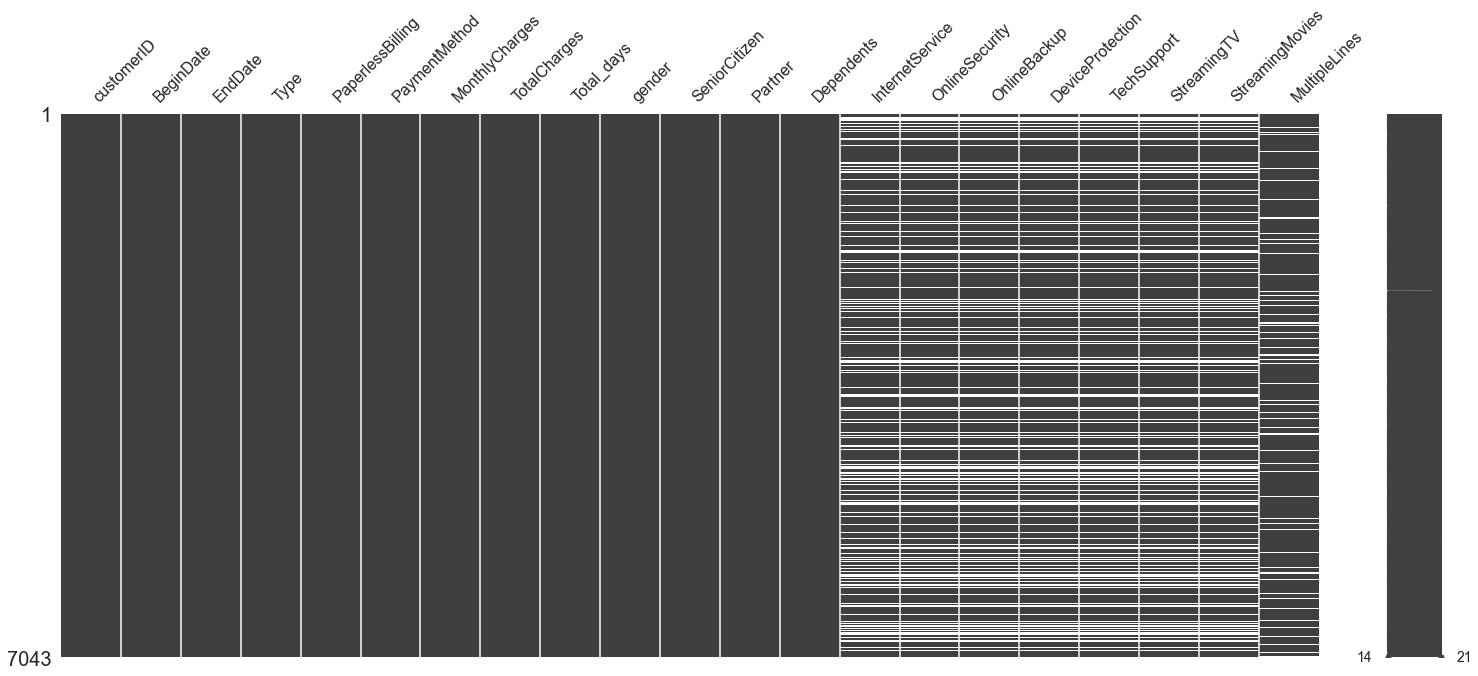

In [39]:
msno.matrix(df)

Известно из условия, что компания предоставляет 2 основных типа услуг - связь и интернет. Все дополнительные услуги связаны с интернетом, тогда пропуски означают, что данные пользователи используют только услуги связи. А пропуски в MultipleLines наоборот, что пользователи подключили только интернет.

In [40]:
df[df['InternetService'].isna() & df['MultipleLines'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Total_days,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines


нет пользователей у которых были бы пропуски в столбцах с услугами связи и интернета одновременно, значит могу заполнить пропуски 3 значением - "отключен" (disabled)

In [41]:
df = df.fillna('No')
df.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Total_days          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

также данная информация дает возможность создать новый признак - тип услуги, которым пользуется клиент.

In [42]:
df['Service_type'] = np.where(
    df['InternetService'] == 'No', 'stationary_phones', np.where(
    df['MultipleLines'] == 'No', 'internet', 'all'))

In [43]:
df['Service_type'].value_counts()

internet             2888
all                  2629
stationary_phones    1526
Name: Service_type, dtype: int64

выделяю целевой призкан Churn по столбцу EndDate

In [44]:
df['Churn'] = (df['EndDate'] != '2020-02-01').astype(int)

удаляю столбцы EndDate, BeginDate и customerID т.к. они бесполезны как признаки;

In [45]:
df = df.drop(['EndDate', 'BeginDate', 'customerID'], axis=1)

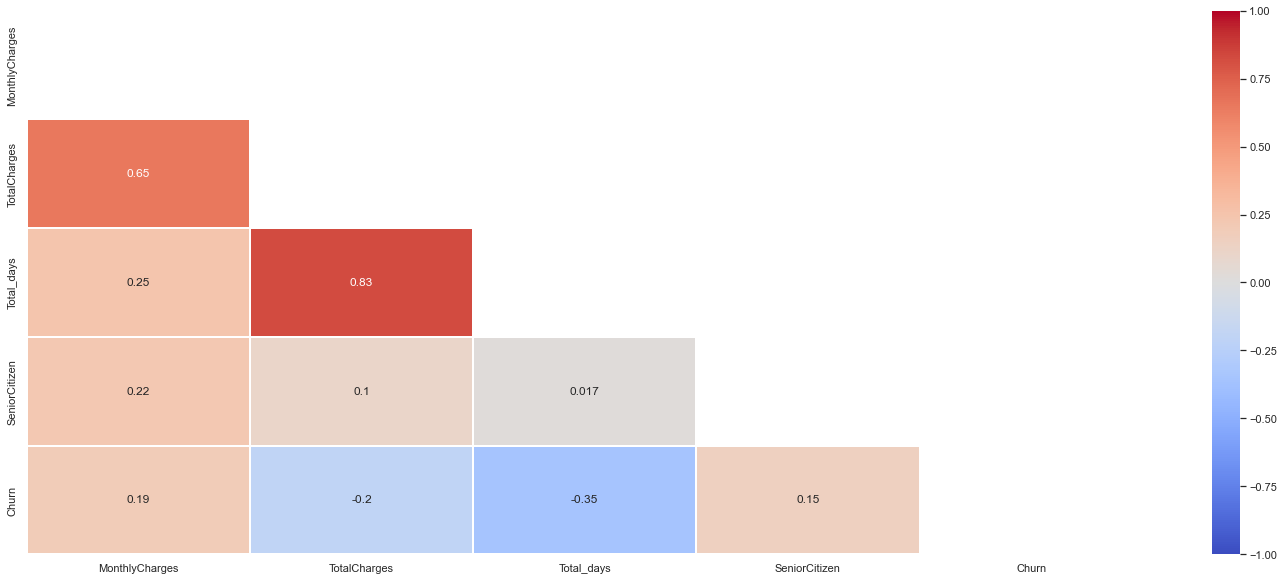

In [46]:
plt.figure(figsize=(25, 10))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, 
                 annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

Сильная связь между total_charges и total_days, monthly_charges

### Кодировка признаков

In [47]:
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

In [48]:
categor_cols = df.select_dtypes(['object']).columns
categor_cols

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen',
       'Partner', 'Dependents', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MultipleLines', 'Service_type'],
      dtype='object')

Для кодировки категориальных данных буду использовать метод get_dummies, т.к. данные являются номинальными.

In [49]:
df = pd.get_dummies(df, columns = categor_cols, drop_first = True)

In [50]:
df.corr()['Churn'].sort_values(ascending = False)

Churn                                    1.000000
InternetService_Fiber optic              0.308020
PaymentMethod_Electronic check           0.301919
MonthlyCharges                           0.193356
PaperlessBilling_Yes                     0.191825
SeniorCitizen_Yes                        0.150889
Service_type_internet                    0.097819
StreamingTV_Yes                          0.063228
StreamingMovies_Yes                      0.061382
MultipleLines_Yes                        0.040102
gender_Male                             -0.008612
DeviceProtection_Yes                    -0.066160
OnlineBackup_Yes                        -0.082255
PaymentMethod_Mailed check              -0.091683
PaymentMethod_Credit card (automatic)   -0.134302
Partner_Yes                             -0.150448
Dependents_Yes                          -0.164221
TechSupport_Yes                         -0.164674
OnlineSecurity_Yes                      -0.171226
Type_One year                           -0.177820


### Дисбаланс классов

0    5174
1    1869
Name: Churn, dtype: int64


<AxesSubplot:xlabel='Churn', ylabel='Count'>

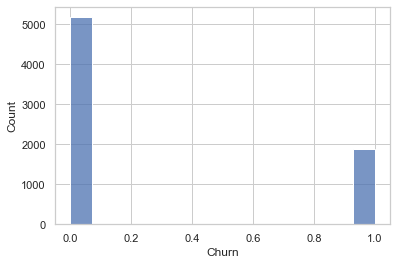

In [51]:
print(df['Churn'].value_counts())
sns.histplot(data=df['Churn'])

у целевого признака довольно сильный дисбаланс классов, для борьбы с ним я буду использовать параметр class_weight='balanced', для catboost - scale_pos_weight 

### Масштабирование количественных признаков

In [52]:
df[['MonthlyCharges', 'TotalCharges', 'Total_days']].describe()

,MonthlyCharges,TotalCharges,Total_days
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,985.996166
std,30.090047,2266.794470,747.587844
min,18.250000,0.000000,0.000000
25%,35.500000,398.550000,273.000000
50%,70.350000,1394.550000,883.000000
75%,89.850000,3786.600000,1676.000000
max,118.750000,8684.800000,2191.000000


In [53]:
X = df.drop(columns = ['Churn'])
y = df['Churn']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = r_s, shuffle=False)

In [55]:
num_cols = df[['MonthlyCharges', 'TotalCharges', 'Total_days']].columns

scaler= StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

теперь данные готовы к обучению

In [56]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 0 to 5281
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         5282 non-null   float64
 1   TotalCharges                           5282 non-null   float64
 2   Total_days                             5282 non-null   float64
 3   Type_One year                          5282 non-null   uint8  
 4   Type_Two year                          5282 non-null   uint8  
 5   PaperlessBilling_Yes                   5282 non-null   uint8  
 6   PaymentMethod_Credit card (automatic)  5282 non-null   uint8  
 7   PaymentMethod_Electronic check         5282 non-null   uint8  
 8   PaymentMethod_Mailed check             5282 non-null   uint8  
 9   gender_Male                            5282 non-null   uint8  
 10  SeniorCitizen_Yes                      5282 non-null   uint8  
 11  Part

## Обучение моделей

### Logistic Regression

In [57]:
%%time

lr = LogisticRegression(class_weight='balanced')

lr_param = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
cv = KFold(n_splits=5, shuffle=True, random_state=r_s)

lr_model = GridSearchCV(lr, lr_param, scoring='roc_auc', cv=cv)
lr_model.fit(X_train, y_train)
print('roc-auc', lr_model.best_score_)

roc-auc 0.8463076827806182
CPU times: user 1.72 s, sys: 32.7 ms, total: 1.76 s
Wall time: 916 ms


### RandomForestClassifier

In [58]:
rf = RandomForestClassifier(random_state=r_s, class_weight='balanced')

param_grid = { 
    'n_estimators': [30, 60, 100, 130],
    'max_depth' : [5,6,7,10],
    'criterion' :['gini', 'entropy']
}

cv = KFold(n_splits=7, shuffle=True, random_state=r_s)

In [59]:
%%time

model_rf = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='roc_auc', cv=cv)
model_rf.fit(X_train, y_train)
print('roc-auc', model_rf.best_score_)

roc-auc 0.858063916589146
CPU times: user 57.5 s, sys: 646 ms, total: 58.2 s
Wall time: 58.4 s


### CatBoostClassifier

In [60]:
param_cb = {'depth': [4,5,6,7,8,9,10],
            'learning_rate': [0.01,0.05, 0.9],
            'iterations': [4, 8, 12, 20] }

cv = KFold(n_splits=7, shuffle=True, random_state=r_s)

cbc = CatBoostClassifier(random_state=r_s, verbose=0, scale_pos_weight=2.8)

In [61]:
%%time
model_cbc = GridSearchCV(estimator=cbc, param_grid = param_cb, cv = cv, scoring='roc_auc')
model_cbc.fit(X_train, y_train)
print('roc-auc', model_cbc.best_score_)

roc-auc 0.8768874475468146
CPU times: user 1min 49s, sys: 3.33 s, total: 1min 52s
Wall time: 41.1 s


лучшую метрику roc-auc показала модель CatBoostClassifier

### Проверка модели на тестовой выборке

roc-auc 0.8812403495595047


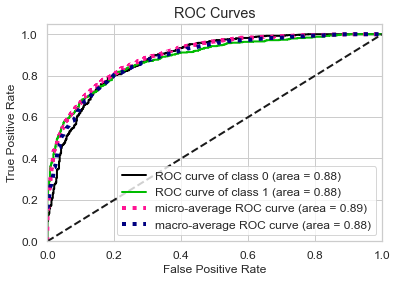

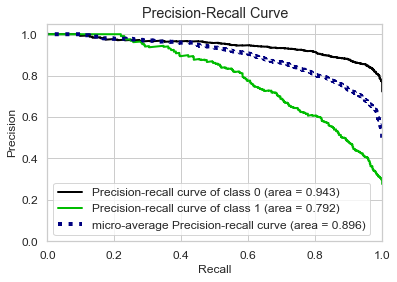

In [71]:
y_pred_proba = model_cbc.predict_proba(X_test)
print('roc-auc', roc_auc_score(y_test, y_pred_proba[:,1]))

skplt.metrics.plot_roc(y_test, y_pred_proba)
plt.show()
skplt.metrics.plot_precision_recall(y_test, y_pred_proba)
plt.show()

<AxesSubplot:>

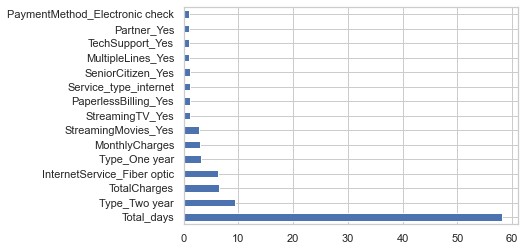

In [91]:
(pd.Series(model_cbc.best_estimator_.feature_importances_, index=X_test.columns)
   .nlargest(15)
   .plot(kind='barh'))

Модель неплохо обучилась и показала хорошие результаты на тестовой выборке

## Вывод

Для прогноза оттока пользователей, важными признаками являются - сколько пользователь пользуется услугами и сколько он платит в месяц.
Лучшие метрики удалось получить у модели CatBoostClassifier.